The NOAA HRRR is a real-time 3km resolution, hourly updated, cloud-resolving, convection-allowing atmospheric model, initialized by 3km grids with 3km radar assimilation.

This notebook provides an example of accessing HRRR data, including (1) finding the data file corresponding to a date and time, (2) retrieving a portion of that file from blob storage which includes the surface temperature variable, (3) opening the file using the xarray library, and (4) rendering an image of the forecast.

This dataset is documented at http://aka.ms/ai4edata-hrrr.

In [21]:
import io
from datetime import date, timedelta, datetime

import pandas as pd
import xarray as xr
import requests
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import cmocean
import tempfile

# Not used directly, but used via xarray
import cfgrib #you need to install some dependencies: https://pypi.org/project/cfgrib/0.8.4.5/ and also look here https://github.com/ecmwf/eccodes-python/issues/54

In [22]:
metadata = pd.read_csv("../data/metadata.csv")

In [23]:
metadata.head()

,uid,latitude,longitude,date,split
0,aabm,39.080319,-86.430867,2018-05-14,train
1,aabn,36.559700,-121.510000,2016-08-31,test
2,aacd,35.875083,-78.878434,2020-11-19,train
3,aaee,35.487000,-79.062133,2016-08-24,train
4,aaff,38.049471,-99.827001,2019-07-23,train


In [24]:
def get_temp(day_date, lat, lon):
    blob_container = "https://noaahrrr.blob.core.windows.net/hrrr"
    sector = "conus"
    yesterday = day_date
    cycle = 12 
    forecast_hour = 1   # offset from cycle time
    product = "wrfsfcf" # 2D surface levels
    # Put it all together
    file_path = f"hrrr.t{cycle:02}z.{product}{forecast_hour:02}.grib2"
    url = f"{blob_container}/hrrr.{yesterday:%Y%m%d}/{sector}/{file_path}"
    
    r = requests.get(f"{url}.idx")
    idx = r.text.splitlines()
    
    sfc_temp_idx = [l for l in idx if ":TMP:surface" in l][0].split(":")
    # Pluck the byte offset from this line, plus the beginning offset of the next line
    line_num = int(sfc_temp_idx[0])
    range_start = sfc_temp_idx[1]
    # The line number values are 1-indexed, so we don't need to increment it to get the next list index,
    # but check we're not already reading the last line
    next_line = idx[line_num].split(':') if line_num < len(idx) else None
    # Pluck the start of the next byte offset, or nothing if we were on the last line
    range_end = next_line[1] if next_line else None

    file = tempfile.NamedTemporaryFile(prefix="tmp_", delete=False)
    headers = {"Range": f"bytes={range_start}-{range_end}"}
    resp = requests.get(url, headers=headers, stream=True)
    with file as f:
        f.write(resp.content)
    ds = xr.open_dataset(file.name, engine='cfgrib', 
                     backend_kwargs={'indexpath':''})
    return ds

In [25]:
def get_temp_aws(day_date, lat, lon):
    blob_container = "https://noaahrrr.blob.core.windows.net/hrrr"
    sector = "conus"
    yesterday = day_date
    cycle = 1 
    forecast_hour = 1   # offset from cycle time
    product = "wrfsfcf" # 2D surface levels
    # Put it all together
    file_path = f"hrrr.t{cycle:02}z.{product}{forecast_hour:02}.grib2"
    url = f"https://noaa-hrrr-bdp-pds.s3.amazonaws.com/hrrr.{yesterday:%Y%m%d}/{sector}/{file_path}"
    
    
    r = requests.get(f"{url}.idx")
    idx = r.text.splitlines()
    
    sfc_temp_idx = [l for l in idx if ":TMP:surface" in l][0].split(":")
    # Pluck the byte offset from this line, plus the beginning offset of the next line
    line_num = int(sfc_temp_idx[0])
    range_start = sfc_temp_idx[1]
    # The line number values are 1-indexed, so we don't need to increment it to get the next list index,
    # but check we're not already reading the last line
    next_line = idx[line_num].split(':') if line_num < len(idx) else None
    # Pluck the start of the next byte offset, or nothing if we were on the last line
    range_end = next_line[1] if next_line else None

    file = tempfile.NamedTemporaryFile(prefix="tmp_", delete=False)
    headers = {"Range": f"bytes={range_start}-{range_end}"}
    resp = requests.get(url, headers=headers, stream=True)
    with file as f:
        f.write(resp.content)
    ds = xr.open_dataset(file.name, engine='cfgrib', 
                     backend_kwargs={'indexpath':''})
    return ds.t.data[lat][lon], 




In [26]:
start_date = datetime.strptime('2023-01-26', '%Y-%m-%d').date()#funktioniert
ds = get_temp(start_date, 1, 1)

In [27]:
def get_start_date(start_date):
    return datetime.strptime(start_date, '%Y-%m-%d').date()

In [28]:
start_date = get_start_date(metadata.date[0])

temp_list = []
for x in range(7):
    day_date = start_date - timedelta(days=x)
    print(day_date)
    temperature = get_temp_aws(day_date, 1 ,1)##input changed
    temp_list.append(temperature)
temp_list


2018-05-14
2018-05-13
2018-05-12
2018-05-11
2018-05-10
2018-05-09
2018-05-08


[(295.3599,),
 (294.99048,),
 (294.5654,),
 (294.70593,),
 (294.87402,),
 (294.5728,),
 (294.59448,)]

In [29]:
date_list = metadata.date.unique()
date_list[1]
(metadata[metadata.date == date_list[1]])#len = 82
for date in dates:
    for i in range(len(metadata[metadata.date == date])):
        lon = metadata.longitude[i]
        lat = metadata.latitude[i]

NameError: name 'dates' is not defined

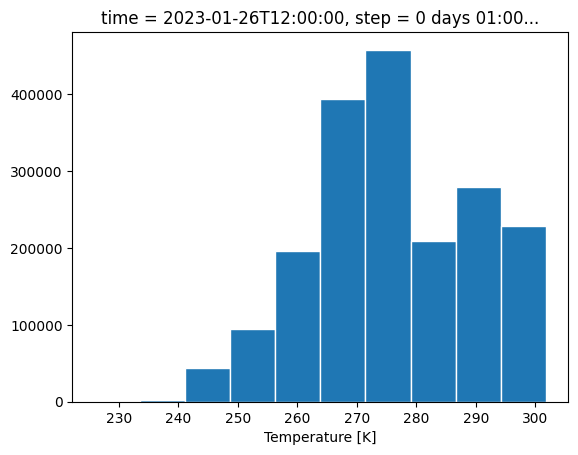

In [30]:
ds.t.plot.hist(edgecolor="white")
plt.show()

In [82]:
ds.t.attrs

{'GRIB_paramId': 130,
 'GRIB_dataType': 'fc',
 'GRIB_numberOfPoints': 1905141,
 'GRIB_typeOfLevel': 'surface',
 'GRIB_stepUnits': 1,
 'GRIB_stepType': 'instant',
 'GRIB_gridType': 'lambert',
 'GRIB_DxInMetres': 3000.0,
 'GRIB_DyInMetres': 3000.0,
 'GRIB_LaDInDegrees': 38.5,
 'GRIB_Latin1InDegrees': 38.5,
 'GRIB_Latin2InDegrees': 38.5,
 'GRIB_LoVInDegrees': 262.5,
 'GRIB_NV': 0,
 'GRIB_Nx': 1799,
 'GRIB_Ny': 1059,
 'GRIB_cfName': 'air_temperature',
 'GRIB_cfVarName': 't',
 'GRIB_gridDefinitionDescription': 'Lambert Conformal can be secant or tangent, conical or bipolar',
 'GRIB_iScansNegatively': 0,
 'GRIB_jPointsAreConsecutive': 0,
 'GRIB_jScansPositively': 1,
 'GRIB_latitudeOfFirstGridPointInDegrees': 21.138123,
 'GRIB_latitudeOfSouthernPoleInDegrees': 0.0,
 'GRIB_longitudeOfFirstGridPointInDegrees': 237.280472,
 'GRIB_longitudeOfSouthernPoleInDegrees': 0.0,
 'GRIB_missingValue': 3.4028234663852886e+38,
 'GRIB_name': 'Temperature',
 'GRIB_shortName': 't',
 'GRIB_units': 'K',
 'long_na

In [75]:
ds

<xarray.Dataset>
Dimensions:     (y: 1059, x: 1799)
Coordinates:
    time        datetime64[ns] 2023-01-26T12:00:00
    step        timedelta64[ns] 01:00:00
    surface     float64 0.0
    latitude    (y, x) float64 21.14 21.15 21.15 21.16 ... 47.86 47.85 47.84
    longitude   (y, x) float64 237.3 237.3 237.3 237.4 ... 299.0 299.0 299.1
    valid_time  datetime64[ns] 2023-01-26T13:00:00
Dimensions without coordinates: y, x
Data variables:
    t           (y, x) float32 294.4 294.4 294.4 294.4 ... 273.6 273.6 273.7
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    history:                 2023-01-30T17:49 GRIB to CDM+CF via cfgrib-0.9.1...

In [91]:
#ds.t.plot(x='longitude', y='latitude')
ds.t.values[1][1]

294.38602

In [78]:
ds.t.attr

AttributeError: 'DataArray' object has no attribute 'attr'

In [50]:
attrs = ds.t.attrs

assert attrs['GRIB_gridType'] == 'lambert'

# Define the CRS with attributes from the temperate DataArray
prj_kwargs = dict(
    globe=ccrs.Globe(ellipse='sphere'),
    central_latitude=attrs['GRIB_LaDInDegrees'],
    central_longitude=attrs['GRIB_LoVInDegrees'],
    standard_parallels=(attrs['GRIB_Latin1InDegrees'],\
                        attrs['GRIB_Latin2InDegrees'])
)

prj = ccrs.LambertConformal(**prj_kwargs)


In [79]:
metadata.head()

,uid,latitude,longitude,date,split
0,aabm,39.080319,-86.430867,2018-05-14,train
1,aabn,36.559700,-121.510000,2016-08-31,test
2,aacd,35.875083,-78.878434,2020-11-19,train
3,aaee,35.487000,-79.062133,2016-08-24,train
4,aaff,38.049471,-99.827001,2019-07-23,train


In [66]:
x, y = prj.transform_point(-86.430867, 39.080319, ccrs.PlateCarree()) 
print(x,y)

953195.906895982 121917.01269952599


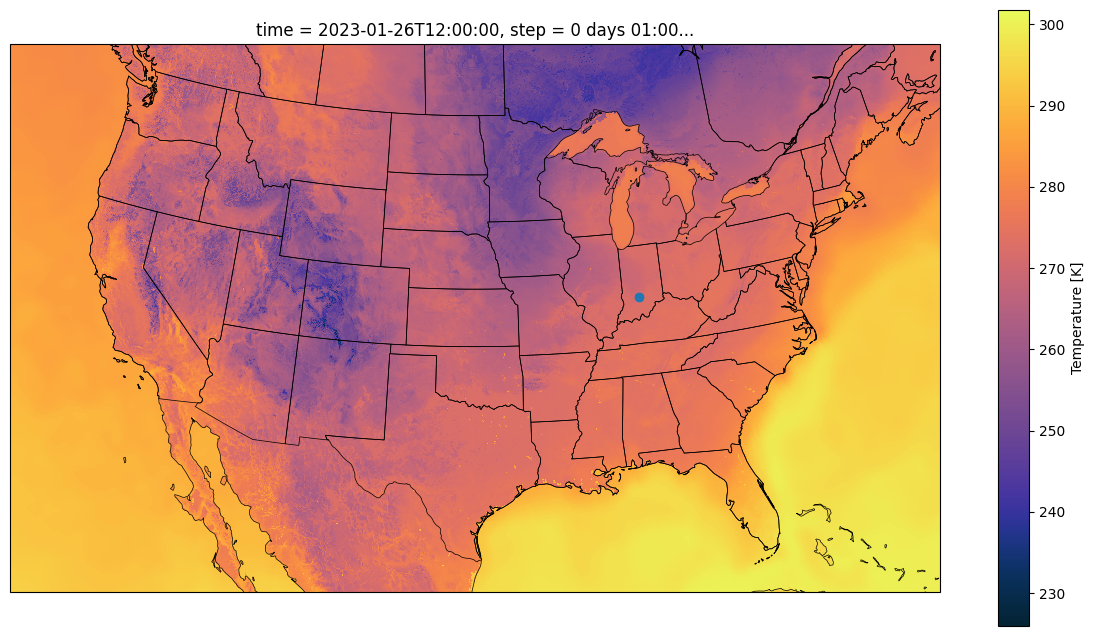

In [84]:
# Ignore some matplotlib deprecation warnings
import warnings; warnings.simplefilter("ignore")

fig = plt.figure(figsize=(15,8))
ax = plt.axes(projection=prj)
plt_kwargs = dict(x='longitude', y='latitude', cmap=cmocean.cm.thermal, 
                  transform=ccrs.PlateCarree())

ds.t.plot(**plt_kwargs, ax=ax)
ax.coastlines(linewidth=0.5)
plt.scatter(x = 953195.906895982, y= 121917.01269952599)# plots the one coordinate :)
ax.add_feature(cfeature.STATES.with_scale('50m'), linewidth=0.5)
plt.show()

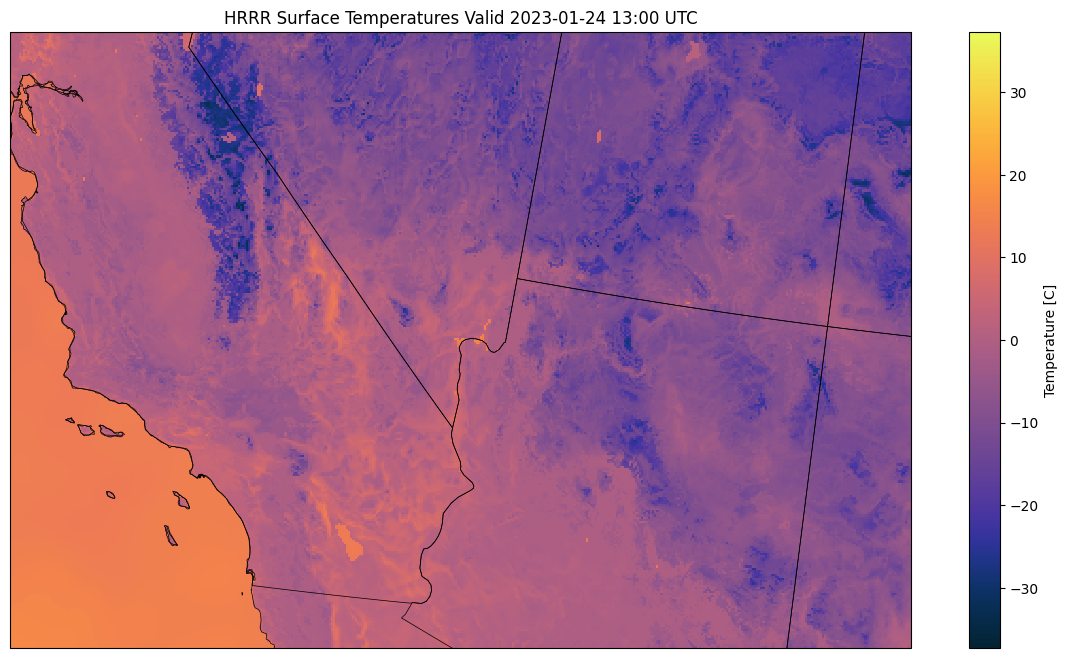

In [30]:
# Increase the dpi a bit for some crisper text
fig = plt.figure(figsize=(15,8), dpi=100)
ax = plt.axes(projection=prj)

# K to C
with xr.set_options(keep_attrs=True):
    t_c = ds.t - 273.15
    t_c.attrs["units"] = "C"

# Add some context and zoom to the SW
ax.coastlines(linewidth=0.5)
ax.add_feature(cfeature.STATES.with_scale('50m'), linewidth=0.5)
ax.set_extent([-121, -108, 33, 39], crs=ccrs.PlateCarree())

t_c.plot(**plt_kwargs, ax=ax)
d = ds.coords['valid_time'].values

plt.title(f"HRRR Surface Temperatures Valid {yesterday} {cycle + forecast_hour:02}:00 UTC")
plt.show()

In [92]:
ds

<xarray.Dataset>
Dimensions:     (y: 1059, x: 1799)
Coordinates:
    time        datetime64[ns] 2023-01-26T12:00:00
    step        timedelta64[ns] 01:00:00
    surface     float64 0.0
    latitude    (y, x) float64 21.14 21.15 21.15 21.16 ... 47.86 47.85 47.84
    longitude   (y, x) float64 237.3 237.3 237.3 237.4 ... 299.0 299.0 299.1
    valid_time  datetime64[ns] 2023-01-26T13:00:00
Dimensions without coordinates: y, x
Data variables:
    t           (y, x) float32 294.4 294.4 294.4 294.4 ... 273.6 273.6 273.7
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    history:                 2023-01-30T17:49 GRIB to CDM+CF via cfgrib-0.9.1...

In [115]:
import numpy as np
import pandas as pd

np.random.seed(0)
temperature = 15 + 8 * np.random.randn(2, 2, 3)
precipitation = 10 * np.random.rand(2, 2, 3)
lon = [[-99.83, -99.32], [-99.79, -99.23]]
lat = [[42.25, 42.21], [42.63, 42.59]]
time = pd.date_range("2014-09-06", periods=3)
reference_time = pd.Timestamp("2014-09-05")

In [117]:
ds = xr.Dataset(
data_vars=dict(
    temperature=(["x", "y", "time"], temperature),
    precipitation=(["x", "y", "time"], precipitation),
    ),
    coords=dict(
    lon=(["x", "y"], lon),
    lat=(["x", "y"], lat),
    time=time,
    reference_time=reference_time,
    ),
    attrs=dict(description="Weather related data."),
    )
ds

temp = ds.temperature


In [70]:
def get_hrrr_data(timestamp, lat, lon):
   blob_container = 'https://noaahrrr.blob.core.windows.net/hrrr'
   sector = 'conus'
   cycle = 12
   forecast_hour = 1
   product = 'wrfsfcf'
   file_path = f'hrrr.t{cycle:02}z.{product}{forecast_hour:02}.grib2'
   url = f'{blob_container}/hrrr.{timestamp:%Y%m%d}/{sector}/{file_path}'
   # Fetch the idx file by appending the .idx file extension to our already formatted URL
   r = requests.get(f'{url}.idx')
   idx = r.text.splitlines()
   # Let’s grab surface temperature `TMP:surface`.
   sfc_temp_idx = [l for l in idx if ':TMP:surface' in l][0].split(':')
   # Pluck the byte offset from this line, plus the beginning offset of the next line
   line_num = int(sfc_temp_idx[0])
   range_start = sfc_temp_idx[1]
   # The line number values are 1-indexed, so we don’t need to increment it to get the next list index,
   # but check we’re not already reading the last line
   next_line = idx[line_num].split(':') if line_num < len(idx) else None
   # Pluck the start of the next byte offset, or nothing if we were on the last line
   range_end = next_line[1] if next_line else None
   headers = {'Range': f'bytes={range_start}-{range_end}'}
   resp = requests.get(url, headers=headers, stream=True)
   with tempfile.NamedTemporaryFile(prefix='tmp_', delete=False) as file:
       file.write(resp.content)
   ds = xr.open_dataset(file.name, engine='cfgrib',
                        backend_kwargs={'indexpath':''})
   # extract temperature at the specific location
   temperature = ds.TMP_surface.sel(lat=lat, lon=lon, method='nearest').values
   return temperature

In [79]:
import datetime

from datetime import datetime
time = datetime.fromtimestamp(timestamp).strftime("%Y-%m-%d %H:%M:%S")

time =  datetime.datetime(2018, 5, 14, 12)
time

datetime.datetime(2018, 5, 14, 12, 0)